In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import arviz as az

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
np.random.seed(12345)

x = np.linspace(0,8,100)

# Parameters for gaussian
alpha_true = 0.2
beta_true = 0.2
#noise
noise = stats.norm(loc=0,scale=0.02).rvs(size=len(x))

#Gaussian function
gauss = lambda x,alpha_true,beta_true: np.exp(-1*((alpha_true)*x+(beta_true)*x**2))
f = gauss(x=x,alpha_true=alpha_true, beta_true=beta_true)
f = f+noise
f_error = np.ones_like(f)*0.1*f.max()

a:  0.1594069245878383 std:  0.015162826725931262 
 b:  0.2243116076961672 std:  0.00906293739408256


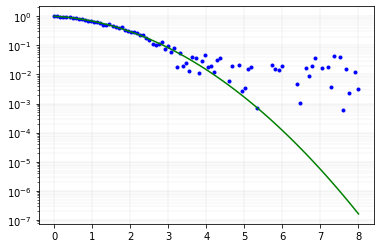

In [12]:
# non linear regression via scipy

def SFmodel(dose,alpha,beta,):
    expterm=(-1)*((alpha*dose)+(beta*dose**2))
    SF = np.exp(expterm)
    return SF

g=[0.4,0.4]
ng,cov=scipy.optimize.curve_fit(SFmodel,x,f,g,sigma=f_error, bounds=(0,np.inf),method="trf")
n=len(x)
sci_fit_y=np.empty(n)
for i in range(n):
    sci_fit_y[i]=SFmodel(x[i],ng[0],ng[1])
stdevs=np.sqrt(np.diag(cov))
plt.yscale('log')
plt.plot(x,f, 'b.')
plt.grid(b=True, which='major', color='grey', linestyle='-', linewidth='0.1')
plt.grid(b=True, which='minor', color='grey', linestyle='--', linewidth='0.1')
plt.plot(sorted(x, reverse=True),sorted(sci_fit_y), 'g-')
print('a: ',ng[0],'std: ', stdevs[0], '\n', 'b: ', ng[1], 'std: ', stdevs[1] )

In [89]:
with pm.Model() as survival_fit_model:
    # Unseen variables - uninformed predictive priors
    alpha = pm.Uniform('alpha', 0, 1, testval= 0.5)
    beta = pm.Uniform('beta', 0, 1, testval= 0.5)

    gauss=pm.Deterministic('gauss',np.exp(-1*((alpha)*x+(beta)*x**2)))
    # Seen variables - likelihood
    # Normal probably not best choice but works for fitting.
    y = pm.Normal('y', mu=gauss, tau=1.0/f_error**2, observed=f)

    start=pm.find_MAP()
    # there were divergences for larger sampling so went overkill on tuning and increased the target acceptance.
    step=pm.NUTS(target_accept=.95)
    trace=pm.sample(5000,start=start, step=step, tune=10000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 10_000 tune and 5_000 draw iterations (40_000 + 20_000 draws total) took 187 seconds.
The number of effective samples is smaller than 25% for some parameters.


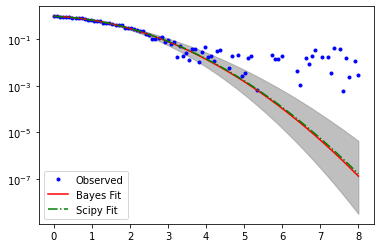

In [91]:
plt.yscale('log')
y_min = np.percentile(trace.gauss,5,axis=0)
y_max = np.percentile(trace.gauss,95,axis=0)
y_fit = np.percentile(trace.gauss,50,axis=0)

plt.plot(x,f, 'b', marker='.', ls='None', label='Observed')
plt.plot(x,y_fit,'r', marker='None', ls='-', ms=5, mew=1, label='Bayes Fit')
plt.plot(x, sci_fit_y, 'g',marker='None', ls='-.', ms=5, mew=1, label='Scipy Fit')
plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()

In [92]:
inference_data = az.from_pymc3(trace)

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\arviz\data\io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [93]:
az.summary(inference_data, var_names=["alpha", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.157,0.070,0.023,0.280,0.001,0.001,4075.0,4029.0,4010.0,4874.0,1.0
beta,0.229,0.042,0.152,0.308,0.001,0.000,4007.0,4007.0,3990.0,3971.0,1.0


c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002179CBF65E0>,
      dtype=object)

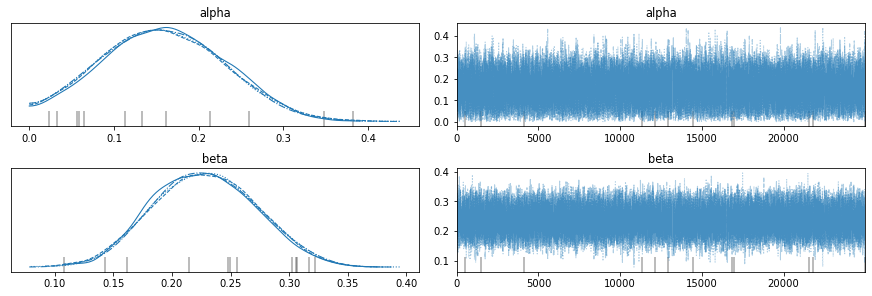

In [80]:
pm.traceplot(inference_data, varnames=["alpha", "beta"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002179E574DF0>,
      dtype=object)

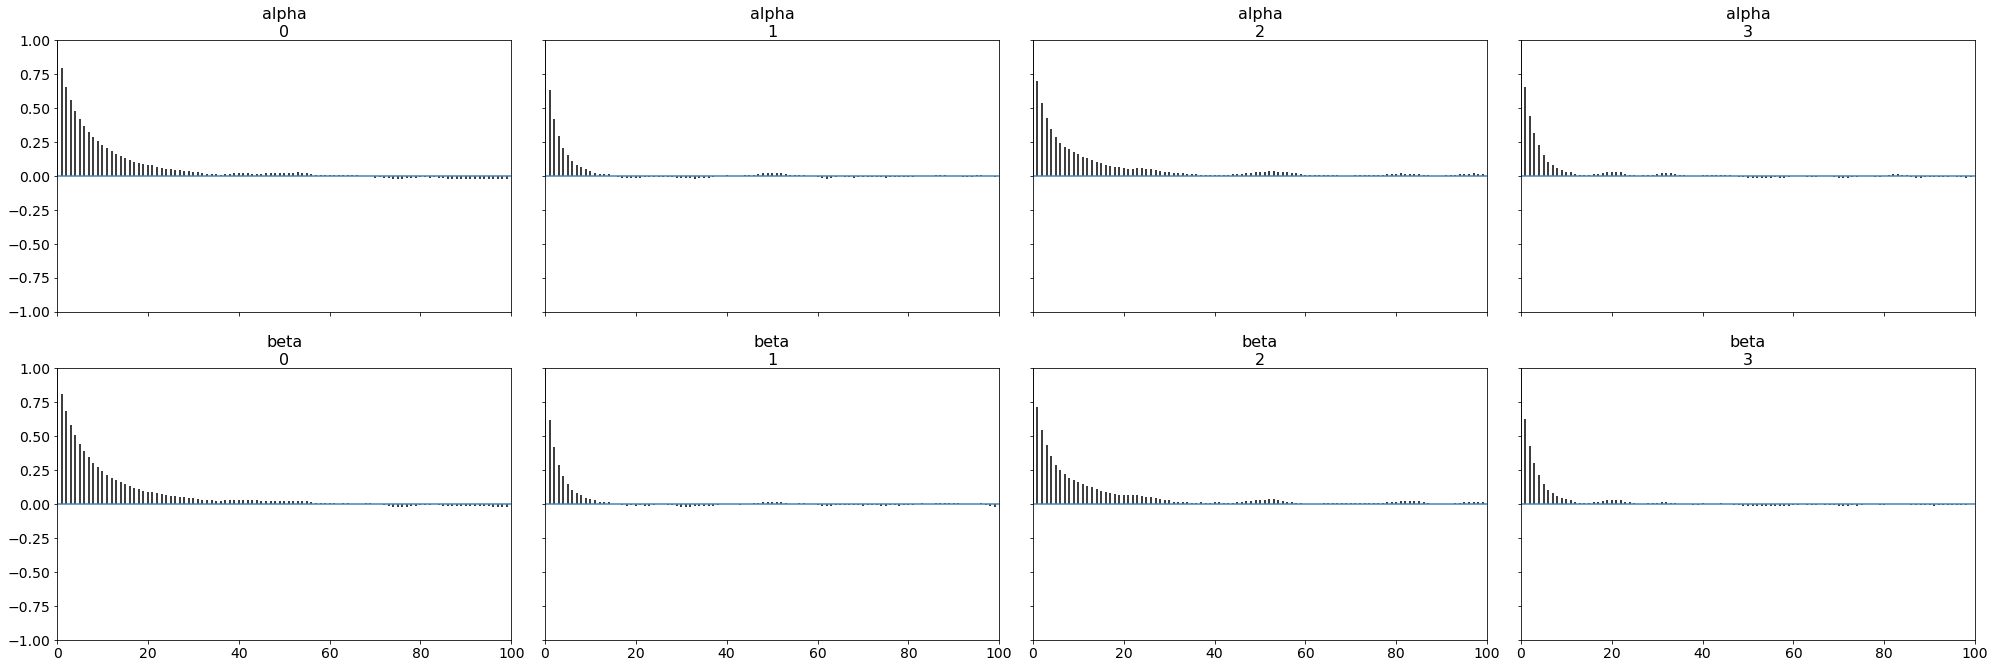

In [81]:
az.plot_autocorr(inference_data,var_names=("alpha", "beta"))

c:\users\aaron\appdata\local\programs\python\python38\lib\site-packages\pymc3\plots\__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000217A1B27F70>,
      dtype=object)

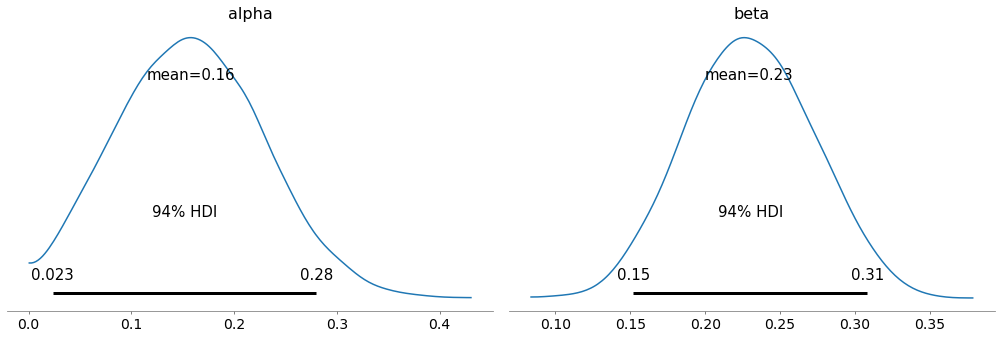

In [94]:
pm.plot_posterior(inference_data,varnames=["alpha", "beta"])